In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 현재 위치 확인
!pwd

/content


In [3]:
# SVD.zip 파일이 있는 주소로 이동 (파일 이름 확인)
# 개인마다 SVD.zip 파일 위치 확인 후 주소 수정
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
# 압축 풀기
!unzip -qq 'SVD.zip'

# Audio Feature Extractions Background

**Audio**

시간에 따른 기압(air pressure)의 변화

**Sampling**

아날로그 신호인 audio 신호를 디지털로 표현하기 위해 잘게 쪼갬

잘게 쪼갠 정보를 디지털 정보로 표현 = sample

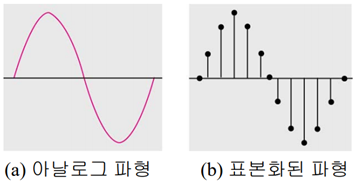

**Sample rate**

1초 당 sample 수, Hz 단위 (e.g. 44.1 KHz = 1초에 44100개 sample)

**Waveform**

아날로그 audio 신호를 sampling을 통해 디지털 신호로 변환한 형태

가로축 = 시간  /  세로축 = 신호의 진폭

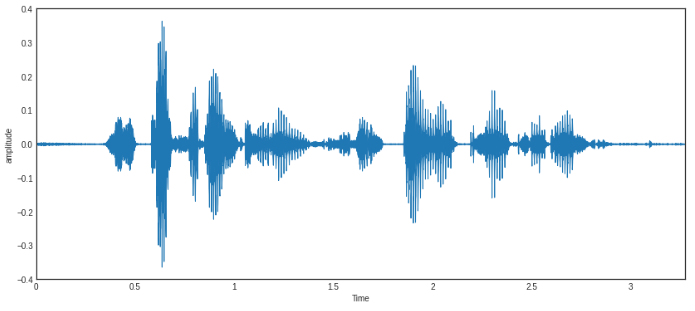

유용한 정보를 추출하기 위해 Fourier Transform (FT) 변환

**Fourier Transform**

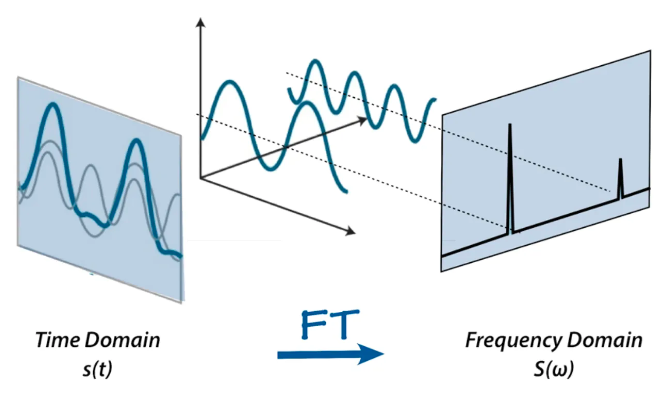

audio 신호는 여러 개의 single-frequency sound waves 로 구성됨

(Frequency = 1초 당 진동수)

Fourier Transform 을 이용해 여러 진동수의 신호가 합쳐져 있는 audio를 각각의 진동수에 따른 신호로 분해함

(Time Domain 신호를 Frequency Domain 으로 변환)

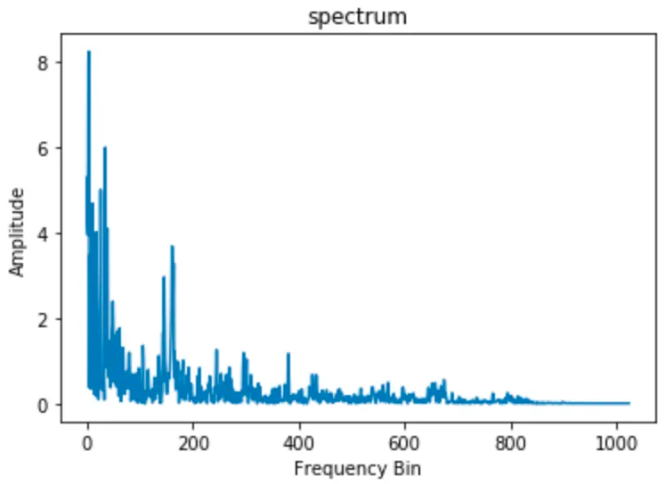

그 결과를 Spectrum 이라고 함

**Spectrogram**

만약 frequency가 시간에 따라 변한다면?

시간에 따라 변하는 신호의 spectrum 들을 나타내는 방법이 필요!

짧은 시간동안의 신호에 FT를 적용 (Short-Time Fourier Transform, STFT)

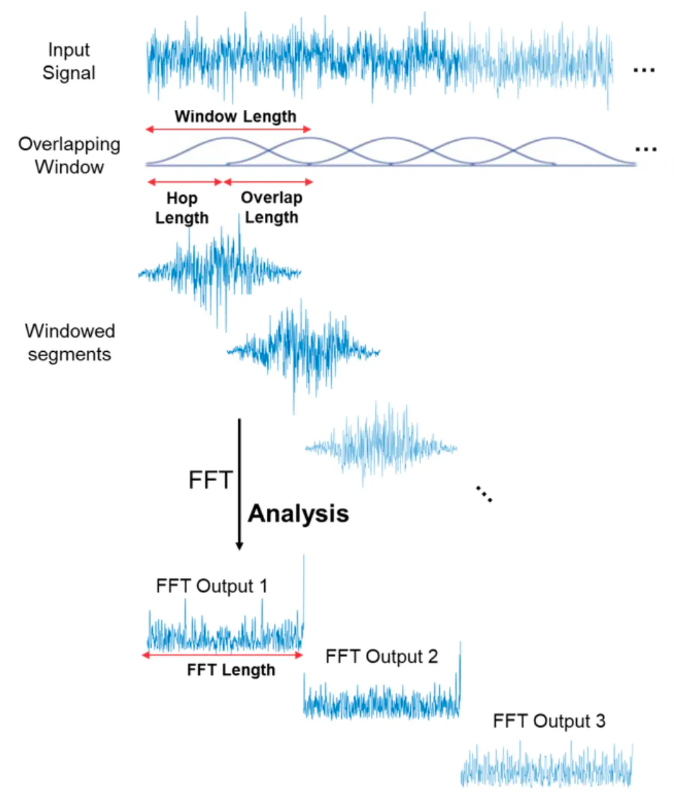

(FFT = Fast Fourier transform)

FFT Output 들의 묶음 = Spectrogram

시간이 지남에 따라 서로 다른 frequency에서 달라지는 신호의 크기를 시각적으로 나타내는 방법

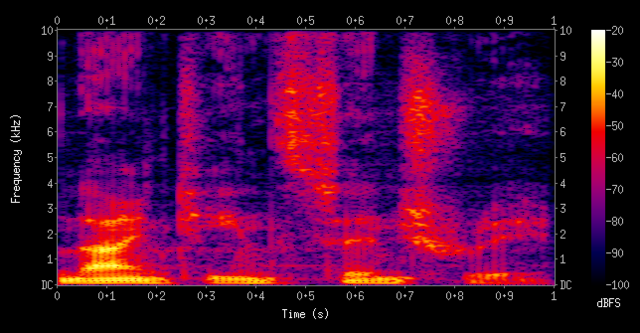

가로축 = 시간 / 세로축 = frequency / 컬러 = 신호세기

(개인적으로 mel-spectrogram, MFCC 공부 권장)

# create spectrogram images

In [5]:
import os
import glob
import torch
import torchaudio
import torchaudio.transforms as T
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [6]:
# 파일 개수 확인
train_healthy_paths = list(glob.glob('./SVD/train/healthy/*.wav'))
train_pathology_paths = list(glob.glob('./SVD/train/pathology/*.wav'))
test_healthy_paths = list(glob.glob('./SVD/test/healthy/*.wav'))
test_pathology_paths = list(glob.glob('./SVD/test/pathology/*.wav'))
print(f'train healthy   : {len(train_healthy_paths)} audios')
print(f'train_pathology : {len(train_pathology_paths)} audios')
print(f'test_healthy    : {len(test_healthy_paths)} audios')
print(f'test_pathology  : {len(test_pathology_paths)} audios')

train healthy   : 532 audios
train_pathology : 762 audios
test_healthy    : 100 audios
test_pathology  : 100 audios


In [7]:
def plot_waveform(path):

    name = os.path.basename(path)
    waveform, sample_rate = torchaudio.load(path)
    print(f'{name}')
    print(f'Shape of waveform: {waveform.shape}')
    print(f'Sample rate: {sample_rate}')
    plt.figure()
    plt.plot(waveform[0].numpy())

In [8]:
def show_spectrogram(path):

    name = os.path.basename(path)
    print(f'{name}')
    waveform, sample_rate = torchaudio.load(path)
    spectrogram = T.Spectrogram(n_fft=512) # Define transform
    spec = spectrogram(waveform) # Perform transform
    plt.figure()
    plt.imshow(librosa.power_to_db(spec[0]), origin='lower')

1002-phrase.wav
Shape of waveform: torch.Size([1, 105802])
Sample rate: 50000


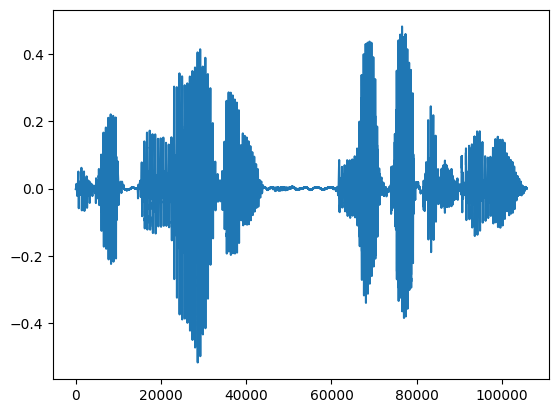

In [9]:
# healthy example
path = train_healthy_paths[1]
plot_waveform(path)
waveform, sample_rate = torchaudio.load(path)
ipd.Audio(waveform[0].numpy(), rate=sample_rate)

1002-phrase.wav


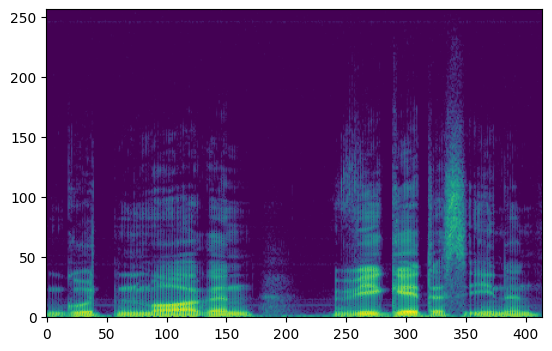

In [10]:
# healthy example
show_spectrogram(path)

1038-phrase.wav
Shape of waveform: torch.Size([1, 118008])
Sample rate: 50000


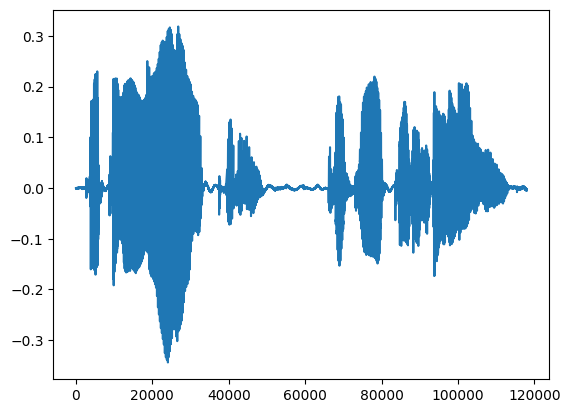

In [11]:
# pathology example
path = train_pathology_paths[1]
plot_waveform(path)
waveform, sample_rate = torchaudio.load(path)
ipd.Audio(waveform[0].numpy(), rate=sample_rate)

1038-phrase.wav


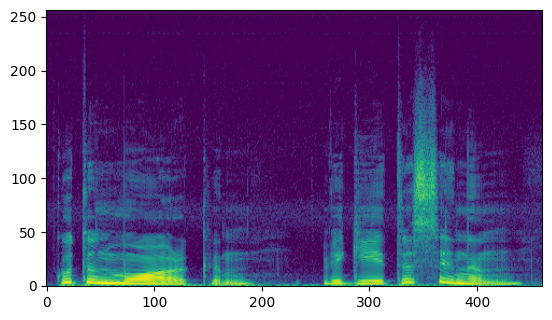

In [12]:
# pathology example
show_spectrogram(path)

In [13]:
# dataset 정의
def load_audios(paths):

    paths = paths
    dataset = []
    for p in paths:
        name = os.path.basename(p)
        name = os.path.splitext(name)[0]
        waveform, sample_rate = torchaudio.load(p)
        dataset.append([waveform, sample_rate, name])

    return dataset

In [14]:
# dataset 생성
h_train = load_audios(train_healthy_paths)
p_train = load_audios(train_pathology_paths)
h_test = load_audios(test_healthy_paths)
p_test = load_audios(test_pathology_paths)

In [15]:
# dataloader
loader_h_train = DataLoader(h_train, batch_size=1, shuffle=False)
loader_p_train = DataLoader(p_train, batch_size=1, shuffle=False)
loader_h_test = DataLoader(h_test, batch_size=1, shuffle=False)
loader_p_test = DataLoader(p_test, batch_size=1, shuffle=False)

In [16]:
# spectrogram image 생성 함수 정의
def create_spectrogram_images(loader, label, t):

    # Make directory
    dir = f'./SVD/spectrograms/{t}/{label}'
    if os.path.isdir(dir):
        print(f'Data exists for {label}')
    else:
        os.makedirs(dir, exist_ok=True)
        for data in loader:
            waveform = data[0][0]
            name = data[2][0]
            spectrogram = T.Spectrogram(n_fft=512)
            spec = spectrogram(waveform)
            fig = plt.figure()
            plt.imshow(librosa.power_to_db(spec[0]), origin='lower')
            plt.axis('off')
            plt.savefig(f'./SVD/spectrograms/{t}/{label}/{name}.png',
                        bbox_inches='tight', pad_inches=0)
            plt.close()

In [17]:
# spectrogram image 생성 (5분 정도 소요)
create_spectrogram_images(loader_h_train, 'healthy', 'train')
create_spectrogram_images(loader_p_train, 'pathology', 'train')
create_spectrogram_images(loader_h_test, 'healthy', 'test')
create_spectrogram_images(loader_p_test, 'pathology', 'test')

In [18]:
# 파일 개수 확인
train_healthy_images = list(glob.glob('./SVD/spectrograms/train/healthy/*.png'))
train_pathology_images = list(glob.glob('./SVD/spectrograms/train/pathology/*.png'))
test_healthy_images = list(glob.glob('./SVD/spectrograms/test/healthy/*.png'))
test_pathology_images = list(glob.glob('./SVD/spectrograms/test/pathology/*.png'))
print(f'train healthy   : {len(train_healthy_images)} images')
print(f'train_pathology : {len(train_pathology_images)} images')
print(f'test_healthy    : {len(test_healthy_images)} images')
print(f'test_pathology  : {len(test_pathology_images)} images')

train healthy   : 532 images
train_pathology : 762 images
test_healthy    : 100 images
test_pathology  : 100 images


# classification

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet34_Weights
from sklearn.metrics import confusion_matrix

In [20]:
# trainset
train_path = './SVD/spectrograms/train'
trainset = ImageFolder(root=train_path, transform=transforms.Compose([transforms.ToTensor(),
                                                                     transforms.Resize((224, 224))]))
print(trainset)
print(f'\nclass : index\n{trainset.class_to_idx}')

Dataset ImageFolder
    Number of datapoints: 1294
    Root location: ./SVD/spectrograms/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
           )

class : index
{'healthy': 0, 'pathology': 1}


In [21]:
# testset
test_path = './SVD/spectrograms/test'
testset = ImageFolder(root=test_path, transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Resize((224, 224))]))
print(testset)
print(f'\nclass : index\n{testset.class_to_idx}')

Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./SVD/spectrograms/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
           )

class : index
{'healthy': 0, 'pathology': 1}


In [22]:
# dataloader
train_dataloader = DataLoader(trainset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=4, shuffle=False)

In [23]:
# GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [24]:
# 사전학습모델 불러오기
pretrained_model = torchvision.models.resnet34(weights=ResNet34_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:05<00:00, 15.6MB/s]


In [25]:
# 사전학습모델 fc_layer 변경
pretrained_model.fc = nn.Linear(512, 2)

In [26]:
# 모델, 손실함수, 옵티마이저
model = pretrained_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [27]:
# training (10 epoch / 5분 정도 소요)
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[epoch: {epoch+1} / batch: {i+1:3d}] loss: {running_loss/100:.4f}')
            running_loss = 0.0

print('Finished Training')

[epoch: 1 / batch: 100] loss: 0.8097
[epoch: 1 / batch: 200] loss: 0.6586
[epoch: 1 / batch: 300] loss: 0.6170
[epoch: 2 / batch: 100] loss: 0.5804
[epoch: 2 / batch: 200] loss: 0.6188
[epoch: 2 / batch: 300] loss: 0.6194
[epoch: 3 / batch: 100] loss: 0.5665
[epoch: 3 / batch: 200] loss: 0.6438
[epoch: 3 / batch: 300] loss: 0.5879
[epoch: 4 / batch: 100] loss: 0.5833
[epoch: 4 / batch: 200] loss: 0.6583
[epoch: 4 / batch: 300] loss: 0.5718
[epoch: 5 / batch: 100] loss: 0.5689
[epoch: 5 / batch: 200] loss: 0.5747
[epoch: 5 / batch: 300] loss: 0.5408
[epoch: 6 / batch: 100] loss: 0.5079
[epoch: 6 / batch: 200] loss: 0.5310
[epoch: 6 / batch: 300] loss: 0.5598
[epoch: 7 / batch: 100] loss: 0.5080
[epoch: 7 / batch: 200] loss: 0.5227
[epoch: 7 / batch: 300] loss: 0.5269
[epoch: 8 / batch: 100] loss: 0.5379
[epoch: 8 / batch: 200] loss: 0.4923
[epoch: 8 / batch: 300] loss: 0.5001
[epoch: 9 / batch: 100] loss: 0.4665
[epoch: 9 / batch: 200] loss: 0.5154
[epoch: 9 / batch: 300] loss: 0.4798
[

In [28]:
# 학습한 모델 저장
path = './SVD/model.pth'
torch.save(model.state_dict(), path)

In [29]:
# confusion matrix
def confusion(model, loader):

    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())

    cm = confusion_matrix(y_true, y_pred)

    return cm

In [30]:
# confusion matrix
cm = confusion(model, test_dataloader)
print(cm)

[[36 64]
 [ 7 93]]


In [31]:
# metrics
def metrics(cm):

    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = (tp) / (tp + fn)
    precision = (tp) / (tp + fp)
    f1 = (2 * recall * precision) / (recall + precision)

    print(f'accuracy: {accuracy:.4f}, recall: {recall:.4f}, precision: {precision:.4f}, f1: {f1:.4f}')

    return accuracy, recall, precision, f1

In [32]:
# metrics
accuracy, recall, precision, f1 = metrics(cm)

accuracy: 0.6450, recall: 0.9300, precision: 0.5924, f1: 0.7237
